In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks')

In [3]:
import pytorch_optimizer as optim

In [4]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [5]:
import torchvision.datasets
from tqdm import tqdm
import pandas as pd

In [6]:
CIFAR_train = torchvision.datasets.CIFAR100('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR100('./', download=True, train=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [7]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [8]:
len(y_train), len(y_test)

(50000, 10000)

In [9]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [10]:
X_train /= 255.
X_test /= 255.

In [11]:
CIFAR_train.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

tensor(19) tensor(29) tensor(0) tensor(11) tensor(1) tensor(86) tensor(90) tensor(28) tensor(23) tensor(31) 

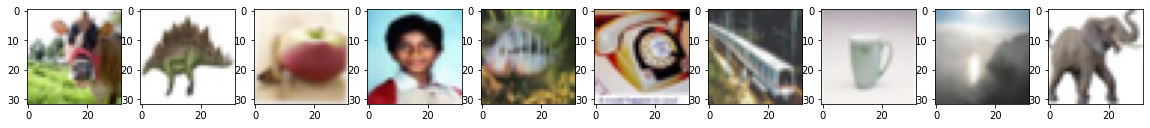

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [13]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [14]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [15]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [28]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)
    optimizer = torch.optim.SGD(net.parameters(), lr=1.0e-2)
    #optimizer = optim.PNMBelief(net.parameters(), lr=0.001)
    #optimizer = optim.YogiPNM(net.parameters(), lr=0.001)
    #optimizer = optim.AdaBelief(net.parameters())
    #optimizer = optim.DiffGrad(net.parameters())
    #optimizer = optim.Yogi(net.parameters())
    
    batch_size = 200

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(20):
        print("epoch ", epoch)
        order = np.random.permutation(len(X_train))
        

        for start_index in tqdm(range(0, len(X_train), batch_size)):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            #print(test_preds.argmax(dim=1))
            #print(y_test)

        print("accuracy = ", accuracy)
        print("\n\n")

    del net

    return test_accuracy_history, test_loss_history

In [17]:
accuracies = {}
losses = {}

In [18]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [25]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+Adam'], losses['resnet50+Adam'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:25<00:00,  9.65it/s]


accuracy =  0.01679999940097332



epoch  1


100%|██████████| 250/250 [00:25<00:00,  9.80it/s]


accuracy =  0.19509999454021454



epoch  2


100%|██████████| 250/250 [00:25<00:00,  9.94it/s]


accuracy =  0.4027999937534332



epoch  3


100%|██████████| 250/250 [00:25<00:00,  9.94it/s]


accuracy =  0.47769999504089355



epoch  4


100%|██████████| 250/250 [00:25<00:00,  9.84it/s]


accuracy =  0.5177000164985657



epoch  5


100%|██████████| 250/250 [00:25<00:00,  9.87it/s]


accuracy =  0.5407999753952026



epoch  6


100%|██████████| 250/250 [00:25<00:00,  9.88it/s]


accuracy =  0.5461999773979187



epoch  7


100%|██████████| 250/250 [00:25<00:00,  9.89it/s]


accuracy =  0.555400013923645



epoch  8


100%|██████████| 250/250 [00:25<00:00,  9.90it/s]


accuracy =  0.5573999881744385



epoch  9


100%|██████████| 250/250 [00:25<00:00,  9.78it/s]


accuracy =  0.5580999851226807



epoch  10


100%|██████████| 250/250 [00:25<00:00,  9.85it/s]


accuracy =  0.5608999729156494



epoch  11


100%|██████████| 250/250 [00:25<00:00,  9.90it/s]


accuracy =  0.568399965763092



epoch  12


100%|██████████| 250/250 [00:25<00:00,  9.86it/s]


accuracy =  0.562999963760376



epoch  13


100%|██████████| 250/250 [00:25<00:00,  9.88it/s]


accuracy =  0.5640999674797058



epoch  14


100%|██████████| 250/250 [00:25<00:00,  9.89it/s]


accuracy =  0.5659999847412109



epoch  15


100%|██████████| 250/250 [00:25<00:00,  9.90it/s]


accuracy =  0.5687999725341797



epoch  16


100%|██████████| 250/250 [00:25<00:00,  9.89it/s]


accuracy =  0.5683000087738037



epoch  17


100%|██████████| 250/250 [00:25<00:00,  9.90it/s]


accuracy =  0.5776999592781067



epoch  18


100%|██████████| 250/250 [00:25<00:00,  9.87it/s]


accuracy =  0.578499972820282



epoch  19


100%|██████████| 250/250 [00:25<00:00,  9.78it/s]


accuracy =  0.5792999863624573





In [29]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+SGD'], losses['resnet50+SGD'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:23<00:00, 10.70it/s]


accuracy =  0.020999999716877937



epoch  1


100%|██████████| 250/250 [00:23<00:00, 10.65it/s]


accuracy =  0.054099999368190765



epoch  2


100%|██████████| 250/250 [00:23<00:00, 10.83it/s]


accuracy =  0.10619999468326569



epoch  3


100%|██████████| 250/250 [00:22<00:00, 10.88it/s]


accuracy =  0.19429999589920044



epoch  4


100%|██████████| 250/250 [00:23<00:00, 10.79it/s]


accuracy =  0.2718999981880188



epoch  5


100%|██████████| 250/250 [00:23<00:00, 10.75it/s]


accuracy =  0.3346000015735626



epoch  6


100%|██████████| 250/250 [00:23<00:00, 10.83it/s]


accuracy =  0.37860000133514404



epoch  7


100%|██████████| 250/250 [00:23<00:00, 10.87it/s]


accuracy =  0.41290000081062317



epoch  8


100%|██████████| 250/250 [00:23<00:00, 10.81it/s]


accuracy =  0.4486999809741974



epoch  9


100%|██████████| 250/250 [00:23<00:00, 10.78it/s]


accuracy =  0.46389999985694885



epoch  10


100%|██████████| 250/250 [00:23<00:00, 10.78it/s]


accuracy =  0.4778999984264374



epoch  11


100%|██████████| 250/250 [00:23<00:00, 10.79it/s]


accuracy =  0.49049997329711914



epoch  12


100%|██████████| 250/250 [00:23<00:00, 10.83it/s]


accuracy =  0.5009999871253967



epoch  13


100%|██████████| 250/250 [00:23<00:00, 10.83it/s]


accuracy =  0.5083000063896179



epoch  14


100%|██████████| 250/250 [00:23<00:00, 10.82it/s]


accuracy =  0.5131999850273132



epoch  15


100%|██████████| 250/250 [00:23<00:00, 10.78it/s]


accuracy =  0.508899986743927



epoch  16


100%|██████████| 250/250 [00:23<00:00, 10.80it/s]


accuracy =  0.5196999907493591



epoch  17


100%|██████████| 250/250 [00:23<00:00, 10.82it/s]


accuracy =  0.5194999575614929



epoch  18


100%|██████████| 250/250 [00:23<00:00, 10.83it/s]


accuracy =  0.5155999660491943



epoch  19


100%|██████████| 250/250 [00:23<00:00, 10.87it/s]


accuracy =  0.5254999995231628





In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+PNMBelief'], losses['resnet50+PNMBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


accuracy =  0.4827999770641327



epoch  1


100%|██████████| 250/250 [00:28<00:00,  8.82it/s]


accuracy =  0.5636999607086182



epoch  2


100%|██████████| 250/250 [00:27<00:00,  8.99it/s]


accuracy =  0.607699990272522



epoch  3


100%|██████████| 250/250 [00:28<00:00,  8.84it/s]


accuracy =  0.615399956703186



epoch  4


100%|██████████| 250/250 [00:28<00:00,  8.91it/s]


accuracy =  0.6161999702453613



epoch  5


100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


accuracy =  0.6290000081062317



epoch  6


100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


accuracy =  0.6233999729156494



epoch  7


100%|██████████| 250/250 [00:28<00:00,  8.76it/s]


accuracy =  0.6284999847412109



epoch  8


100%|██████████| 250/250 [00:28<00:00,  8.70it/s]


accuracy =  0.6279999613761902



epoch  9


100%|██████████| 250/250 [00:28<00:00,  8.92it/s]


accuracy =  0.6281999945640564



epoch  10


100%|██████████| 250/250 [00:27<00:00,  8.95it/s]


accuracy =  0.6280999779701233



epoch  11


100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


accuracy =  0.6245999932289124



epoch  12


100%|██████████| 250/250 [00:28<00:00,  8.87it/s]


accuracy =  0.6377999782562256



epoch  13


100%|██████████| 250/250 [00:27<00:00,  8.95it/s]


accuracy =  0.6301999688148499



epoch  14


100%|██████████| 250/250 [00:28<00:00,  8.92it/s]


accuracy =  0.6287999749183655



epoch  15


100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


accuracy =  0.6376999616622925



epoch  16


100%|██████████| 250/250 [00:27<00:00,  8.97it/s]


accuracy =  0.6358999609947205



epoch  17


100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


accuracy =  0.6473999619483948



epoch  18


100%|██████████| 250/250 [00:27<00:00,  8.97it/s]


accuracy =  0.6414999961853027



epoch  19


100%|██████████| 250/250 [00:27<00:00,  8.96it/s]


accuracy =  0.6377999782562256





In [ ]:
accuracies['resnet50+YogiPNM'], losses['resnet50+YogiPNM'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:28<00:00,  8.75it/s]


accuracy =  0.46859997510910034



epoch  1


100%|██████████| 250/250 [00:28<00:00,  8.76it/s]


accuracy =  0.5827000141143799



epoch  2


100%|██████████| 250/250 [00:28<00:00,  8.83it/s]


accuracy =  0.6072999835014343



epoch  3


100%|██████████| 250/250 [00:28<00:00,  8.73it/s]


accuracy =  0.6164000034332275



epoch  4


100%|██████████| 250/250 [00:28<00:00,  8.88it/s]


accuracy =  0.6225000023841858



epoch  5


100%|██████████| 250/250 [00:28<00:00,  8.91it/s]


accuracy =  0.6230999827384949



epoch  6


100%|██████████| 250/250 [00:28<00:00,  8.87it/s]


accuracy =  0.6312999725341797



epoch  7


100%|██████████| 250/250 [00:28<00:00,  8.85it/s]


accuracy =  0.627299964427948



epoch  8


100%|██████████| 250/250 [00:28<00:00,  8.86it/s]


accuracy =  0.6207999587059021



epoch  9


100%|██████████| 250/250 [00:28<00:00,  8.88it/s]


accuracy =  0.6013999581336975



epoch  10


100%|██████████| 250/250 [00:28<00:00,  8.82it/s]


accuracy =  0.6268999576568604



epoch  11


100%|██████████| 250/250 [00:27<00:00,  8.95it/s]


accuracy =  0.6340000033378601



epoch  12


100%|██████████| 250/250 [00:28<00:00,  8.88it/s]


accuracy =  0.6402999758720398



epoch  13


100%|██████████| 250/250 [00:28<00:00,  8.92it/s]


accuracy =  0.6466999650001526



epoch  14


100%|██████████| 250/250 [00:28<00:00,  8.89it/s]


accuracy =  0.6477000117301941



epoch  15


100%|██████████| 250/250 [00:28<00:00,  8.88it/s]


accuracy =  0.6491999626159668



epoch  16


100%|██████████| 250/250 [00:28<00:00,  8.91it/s]


accuracy =  0.6513999700546265



epoch  17


100%|██████████| 250/250 [00:28<00:00,  8.85it/s]


accuracy =  0.6560999751091003



epoch  18


100%|██████████| 250/250 [00:28<00:00,  8.89it/s]


accuracy =  0.655299961566925



epoch  19


100%|██████████| 250/250 [00:28<00:00,  8.82it/s]


accuracy =  0.6504999995231628





In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+AdaBelief'], losses['resnet50+AdaBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:28<00:00,  8.79it/s]


accuracy =  0.32600000500679016



epoch  1


100%|██████████| 250/250 [00:27<00:00,  9.03it/s]


accuracy =  0.5523999929428101



epoch  2


100%|██████████| 250/250 [00:26<00:00,  9.32it/s]


accuracy =  0.5817999839782715



epoch  3


100%|██████████| 250/250 [00:26<00:00,  9.28it/s]


accuracy =  0.6003999710083008



epoch  4


100%|██████████| 250/250 [00:26<00:00,  9.29it/s]


accuracy =  0.6018999814987183



epoch  5


100%|██████████| 250/250 [00:26<00:00,  9.28it/s]


accuracy =  0.6001999974250793



epoch  6


100%|██████████| 250/250 [00:26<00:00,  9.33it/s]


accuracy =  0.6053000092506409



epoch  7


100%|██████████| 250/250 [00:26<00:00,  9.30it/s]


accuracy =  0.598800003528595



epoch  8


100%|██████████| 250/250 [00:27<00:00,  9.23it/s]


accuracy =  0.5503000020980835



epoch  9


100%|██████████| 250/250 [00:26<00:00,  9.29it/s]


accuracy =  0.5990999937057495



epoch  10


100%|██████████| 250/250 [00:26<00:00,  9.28it/s]


accuracy =  0.6172999739646912



epoch  11


100%|██████████| 250/250 [00:26<00:00,  9.28it/s]


accuracy =  0.609499990940094



epoch  12


100%|██████████| 250/250 [00:26<00:00,  9.30it/s]


accuracy =  0.5997999906539917



epoch  13


100%|██████████| 250/250 [00:26<00:00,  9.28it/s]


accuracy =  0.5928999781608582



epoch  14


100%|██████████| 250/250 [00:26<00:00,  9.30it/s]


accuracy =  0.5863999724388123



epoch  15


100%|██████████| 250/250 [00:26<00:00,  9.29it/s]


accuracy =  0.5722999572753906



epoch  16


100%|██████████| 250/250 [00:26<00:00,  9.31it/s]


accuracy =  0.600600004196167



epoch  17


 86%|████████▌ | 214/250 [00:23<00:03,  9.53it/s]

In [ ]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+DiffGrad'], losses['resnet50+DiffGrad'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:29<00:00,  8.53it/s]


accuracy =  0.4691999852657318



epoch  1


100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


accuracy =  0.5814999938011169



epoch  2


100%|██████████| 250/250 [00:28<00:00,  8.64it/s]


accuracy =  0.6111999750137329



epoch  3


100%|██████████| 250/250 [00:28<00:00,  8.69it/s]


accuracy =  0.6208999752998352



epoch  4


100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


accuracy =  0.6116999983787537



epoch  5


100%|██████████| 250/250 [00:28<00:00,  8.73it/s]


accuracy =  0.616100013256073



epoch  6


100%|██████████| 250/250 [00:28<00:00,  8.63it/s]


accuracy =  0.6211999654769897



epoch  7


100%|██████████| 250/250 [00:28<00:00,  8.69it/s]


accuracy =  0.6200999617576599



epoch  8


100%|██████████| 250/250 [00:29<00:00,  8.61it/s]


accuracy =  0.6191999912261963



epoch  9


100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


accuracy =  0.6237999796867371



epoch  10


100%|██████████| 250/250 [00:28<00:00,  8.69it/s]


accuracy =  0.6143999695777893



epoch  11


100%|██████████| 250/250 [00:28<00:00,  8.69it/s]


accuracy =  0.616599977016449



epoch  12


100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


accuracy =  0.604699969291687



epoch  13


100%|██████████| 250/250 [00:28<00:00,  8.72it/s]


accuracy =  0.6032999753952026



epoch  14


100%|██████████| 250/250 [00:28<00:00,  8.68it/s]


accuracy =  0.6189999580383301



epoch  15


100%|██████████| 250/250 [00:28<00:00,  8.63it/s]


accuracy =  0.6166999936103821



epoch  16


 86%|████████▋ | 216/250 [00:25<00:04,  7.78it/s]

In [19]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
accuracies['resnet50+Yogi'], losses['resnet50+Yogi'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:32<00:00,  7.77it/s]


accuracy =  0.20579999685287476



epoch  1


100%|██████████| 250/250 [00:27<00:00,  9.07it/s]


accuracy =  0.522599995136261



epoch  2


100%|██████████| 250/250 [00:25<00:00,  9.68it/s]


accuracy =  0.5771999955177307



epoch  3


100%|██████████| 250/250 [00:26<00:00,  9.53it/s]


accuracy =  0.593999981880188



epoch  4


100%|██████████| 250/250 [00:26<00:00,  9.44it/s]


accuracy =  0.5974999666213989



epoch  5


100%|██████████| 250/250 [00:25<00:00,  9.74it/s]


accuracy =  0.6029999852180481



epoch  6


100%|██████████| 250/250 [00:25<00:00,  9.74it/s]


accuracy =  0.6046000123023987



epoch  7


100%|██████████| 250/250 [00:25<00:00,  9.75it/s]


accuracy =  0.5995000004768372



epoch  8


100%|██████████| 250/250 [00:25<00:00,  9.74it/s]


accuracy =  0.6057999730110168



epoch  9


100%|██████████| 250/250 [00:25<00:00,  9.73it/s]


accuracy =  0.6110999584197998



epoch  10


100%|██████████| 250/250 [00:25<00:00,  9.76it/s]


accuracy =  0.6173999905586243



epoch  11


100%|██████████| 250/250 [00:25<00:00,  9.74it/s]


accuracy =  0.6096999645233154



epoch  12


100%|██████████| 250/250 [00:25<00:00,  9.74it/s]


accuracy =  0.6040999889373779



epoch  13


100%|██████████| 250/250 [00:25<00:00,  9.76it/s]


accuracy =  0.6067999601364136



epoch  14


100%|██████████| 250/250 [00:25<00:00,  9.69it/s]


accuracy =  0.6140999794006348



epoch  15


100%|██████████| 250/250 [00:25<00:00,  9.74it/s]


accuracy =  0.621399998664856



epoch  16


100%|██████████| 250/250 [00:25<00:00,  9.73it/s]


accuracy =  0.6297999620437622



epoch  17


100%|██████████| 250/250 [00:25<00:00,  9.75it/s]


accuracy =  0.6340999603271484



epoch  18


100%|██████████| 250/250 [00:25<00:00,  9.75it/s]


accuracy =  0.5920000076293945



epoch  19


100%|██████████| 250/250 [00:25<00:00,  9.73it/s]


accuracy =  0.6229999661445618





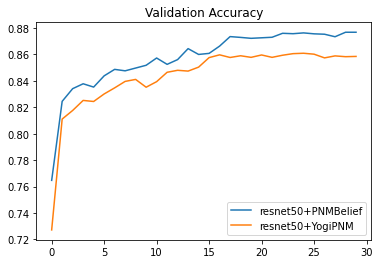

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

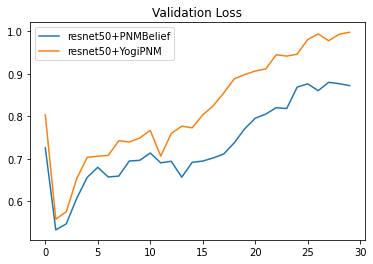

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [ ]:
data = np.zeros((10,10), dtype=int)
D = pd.DataFrame(data)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
test_preds = model.forward(X_test)

In [ ]:
for x, y in zip(test_preds.argmax(dim=1).tolist(), y_test.tolist()):
    D[y][x] += 1

In [ ]:
D # resnet18+PNMBelief

,0,1,2,3,4,5,6,7,8,9
0,879,12,42,15,14,12,8,11,34,19
1,12,906,5,8,2,1,4,2,16,43
2,24,6,793,55,35,39,27,11,7,4
3,14,3,23,635,35,103,19,21,8,6
4,9,0,47,53,838,30,34,28,1,2
5,1,2,28,151,20,753,12,29,2,2
6,3,5,33,39,12,15,888,3,3,3
7,14,3,20,26,30,34,3,882,1,7
8,29,10,5,9,11,4,3,4,917,13
9,15,53,4,9,3,9,2,9,11,901


In [ ]:
D # resnet18

,0,1,2,3,4,5,6,7,8,9
0,878,16,36,22,4,8,8,5,33,15
1,10,905,1,6,1,2,3,3,11,45
2,20,0,817,43,37,32,27,16,11,8
3,9,5,32,693,45,138,49,32,7,8
4,9,1,40,44,822,27,28,18,1,3
5,9,5,33,124,32,746,11,48,3,1
6,4,4,22,27,21,10,867,4,3,3
7,7,1,14,26,30,30,2,861,1,6
8,36,18,3,7,6,3,3,4,916,28
9,18,45,2,8,2,4,2,9,14,883
